In [314]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import os
import sys
import importlib

sys.path.insert(0, "..")

import draughts
import board
import preprocessing
import engine

importlib.reload(draughts);
importlib.reload(board);
importlib.reload(preprocessing);
importlib.reload(engine);

In [297]:
my_board = draughts.Board()
my_board

. o . o . o . o
o . o . o . o .
. o . o . o . o
. . . . . . . .
. . . . . . . .
O . O . O . O .
. O . O . O . O
O . O . O . O .

In [64]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

tf.config.run_functions_eagerly(True)

In [537]:
def get_conv_net():
    model = keras.models.Sequential()
    model.add(layers.Conv2D(128, (2, 2), activation="relu", input_shape=(8, 8, 5)))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D())
#     model.add(layers.Conv2D(128, (2, 2), activation="relu"))
    # model.add(layers.BatchNormalization())
#     model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2()))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation="sigmoid"))

#     sgd = keras.optimizers.SGD(learning_rate=0.01)

    model.compile(optimizer="adam", 
                  loss=keras.losses.MeanSquaredError(), 
                  metrics=["accuracy"])
    
    return model

In [538]:
white_model = get_conv_net()
black_model = get_conv_net()

In [539]:
# white_model.load_weights("new_w_weights.h5")
# black_model.load_weights("new_b_weights.h5")

In [540]:
num_dict = {l : i+1 for i, l in enumerate("abcdefgh")}

def cell_dist(cell1, cell2):
    p1 = np.array([num_dict[cell1[0]], int(cell1[1])])
    p2 = np.array([num_dict[cell2[0]], int(cell2[1])])
    return np.linalg.norm(p1 - p2)


def find_closest_move(move, valid_moves):
    distance = np.inf
    best_moves = []
    for m in valid_moves:
        if move.from_index == m.from_index and move.to_index == m.to_index:
            return move
        dist = cell_dist(move.from_pos, m.from_pos)
        if dist < distance:
            best_moves.append(m)
            distance = dist
            
    closest_move = None
    distance = np.inf
            
    for m in best_moves:
        dist = cell_dist(move.to_pos, m.to_pos)
        if dist < distance:
            closest_move = m
            distance = dist
            
    return closest_move

In [541]:
my_board = draughts.Board()

white_won = 0
black_won = 0
iter_count = 0

In [542]:
def cost_function(w, b):
    return abs(w - b)

In [543]:
def train():
    
    global my_board
    global white_won
    global black_won
    global iter_count
    
    for i in range(20000):
        iter_count += 1
#         if iter_count % 200 == 0:
#             white_model.save_weights("new_w_weights.h5")
#             black_model.save_weights("new_b_weights.h5")
            
        white_train_data = []
        white_test_data = []

        black_train_data = []
        black_test_data = []

        while my_board.engine.is_finished() == engine.GameState.INDETERMINATE or my_board.engine.is_draw():
            b_valid_moves = my_board.valid_moves()
                
            closest_move = None
            
            inp = preprocessing.board_layout_to_network_input(my_board.engine.layout)
            
            if np.random.randint(3) != 0:
                if my_board.engine.turn:
                    net_move = get_network_move(white_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
                elif not my_board.engine.turn:
                    net_move = get_network_move(black_model.predict(np.array([inp]))[0])
                    closest_move = find_closest_move(net_move, b_valid_moves)
            else:
                closest_move = np.random.choice(b_valid_moves)
                
            move_out = preprocessing.move_to_network_output(closest_move)

            if my_board.engine.turn:
                white_train_data.append(inp)
                white_test_data.append(move_out)
            elif not my_board.engine.turn:
                black_train_data.append(inp)
                black_test_data.append(move_out)
                
            my_board.push_move(closest_move)
            
        if not white_train_data or not white_test_data:
            print("PANIC ERROR WHITE")
        
        if not black_train_data or not black_test_data:
            print("PANIC ERROR BLACK")

        if my_board.engine.is_finished() == engine.GameState.WHITE_WON:
            print("White won")
#             cboard = draughts.Board()
#             cboard.engine.layout = preprocessing.network_input_to_board_layout(white_train_data[1])
#             display(cboard.show())
#             print(preprocessing.network_output_to_move(white_test_data[1]))
            white_won += 1
            white_model.fit(np.array(white_train_data), np.array(white_test_data), epochs=10, batch_size=32, verbose=0)
        if my_board.engine.is_finished() == engine.GameState.BLACK_WON:
            print("Black won")
#             cboard = draughts.Board()
#             cboard.engine.layout = preprocessing.network_input_to_board_layout(black_train_data[1])
#             display(cboard.show())
#             print(preprocessing.network_output_to_move(black_test_data[1]))
            black_won += 1
            black_model.fit(np.array(black_train_data), np.array(black_test_data), epochs=10, batch_size=32, verbose=0)

        print("Board evalutation -", my_board.engine.evaluate())
        print("Game difference function ~", cost_function(white_won, black_won))
        my_board.engine.reset()

In [554]:
# def train_function():
#     try:
#         if iter_count != 20000:
#             train()
#     except:
#         train_function()

# train_function()
# import logging
train()

White won
Board evalutation - 9
Game difference function ~ 45
White won
Board evalutation - 11
Game difference function ~ 44
White won
Board evalutation - 8
Game difference function ~ 43
White won
Board evalutation - 7
Game difference function ~ 42
Black won
Board evalutation - -6
Game difference function ~ 43
Black won
Board evalutation - -6
Game difference function ~ 44
Black won
Board evalutation - -7
Game difference function ~ 45
White won
Board evalutation - 8
Game difference function ~ 44
Black won
Board evalutation - -8
Game difference function ~ 45
White won
Board evalutation - 11
Game difference function ~ 44
Black won
Board evalutation - -11
Game difference function ~ 45
Black won
Board evalutation - -6
Game difference function ~ 46
Black won
Board evalutation - -8
Game difference function ~ 47
White won
Board evalutation - 10
Game difference function ~ 46
White won
Board evalutation - 7
Game difference function ~ 45
White won
Board evalutation - 6
Game difference function ~ 

Black won
Board evalutation - -4
Game difference function ~ 34
White won
Board evalutation - 12
Game difference function ~ 33
Black won
Board evalutation - -9
Game difference function ~ 34
White won
Board evalutation - 8
Game difference function ~ 33
White won
Board evalutation - 3
Game difference function ~ 32
Black won
Board evalutation - -8
Game difference function ~ 33
Black won
Board evalutation - -10
Game difference function ~ 34
White won
Board evalutation - 5
Game difference function ~ 33
Black won
Board evalutation - -6
Game difference function ~ 34
White won
Board evalutation - 8
Game difference function ~ 33
White won
Board evalutation - 11
Game difference function ~ 32
Black won
Board evalutation - -7
Game difference function ~ 33
White won
Board evalutation - 4
Game difference function ~ 32
Black won
Board evalutation - -10
Game difference function ~ 33
Black won
Board evalutation - -6
Game difference function ~ 34
Black won
Board evalutation - -9
Game difference function 

White won
Board evalutation - 8
Game difference function ~ 23
White won
Board evalutation - 8
Game difference function ~ 22
White won
Board evalutation - 6
Game difference function ~ 21
White won
Board evalutation - 6
Game difference function ~ 20
Black won
Board evalutation - -4
Game difference function ~ 21
Black won
Board evalutation - -6
Game difference function ~ 22
White won
Board evalutation - 7
Game difference function ~ 21
Black won
Board evalutation - -9
Game difference function ~ 22
White won
Board evalutation - 3
Game difference function ~ 21
White won
Board evalutation - 9
Game difference function ~ 20
Black won
Board evalutation - -10
Game difference function ~ 21
Black won
Board evalutation - -11
Game difference function ~ 22
Black won
Board evalutation - -10
Game difference function ~ 23
Black won
Board evalutation - -10
Game difference function ~ 24
Black won
Board evalutation - -10
Game difference function ~ 25
White won
Board evalutation - 7
Game difference function 

Black won
Board evalutation - -3
Game difference function ~ 26
Black won
Board evalutation - -6
Game difference function ~ 27
Black won
Board evalutation - -3
Game difference function ~ 28
White won
Board evalutation - 8
Game difference function ~ 27
Black won
Board evalutation - -5
Game difference function ~ 28
Black won
Board evalutation - -9
Game difference function ~ 29
White won
Board evalutation - 8
Game difference function ~ 28
Black won
Board evalutation - -4
Game difference function ~ 29
Black won
Board evalutation - -6
Game difference function ~ 30
White won
Board evalutation - 11
Game difference function ~ 29
Black won
Board evalutation - -3
Game difference function ~ 30
White won
Board evalutation - 6
Game difference function ~ 29
Black won
Board evalutation - -10
Game difference function ~ 30
White won
Board evalutation - 6
Game difference function ~ 29
Black won
Board evalutation - -9
Game difference function ~ 30
Black won
Board evalutation - -8
Game difference function 

Black won
Board evalutation - -6
Game difference function ~ 59
White won
Board evalutation - 3
Game difference function ~ 58
Black won
Board evalutation - -9
Game difference function ~ 59
White won
Board evalutation - 3
Game difference function ~ 58
Black won
Board evalutation - -3
Game difference function ~ 59
Black won
Board evalutation - -7
Game difference function ~ 60
White won
Board evalutation - 6
Game difference function ~ 59
White won
Board evalutation - 6
Game difference function ~ 58
White won
Board evalutation - 7
Game difference function ~ 57
White won
Board evalutation - 9
Game difference function ~ 56
Black won
Board evalutation - -8
Game difference function ~ 57
White won
Board evalutation - 2
Game difference function ~ 56
White won
Board evalutation - 10
Game difference function ~ 55
Black won
Board evalutation - -5
Game difference function ~ 56
White won
Board evalutation - 9
Game difference function ~ 55
White won
Board evalutation - 1
Game difference function ~ 54
W

White won
Board evalutation - 3
Game difference function ~ 78
Black won
Board evalutation - -5
Game difference function ~ 79
Black won
Board evalutation - -9
Game difference function ~ 80
Black won
Board evalutation - -9
Game difference function ~ 81
White won
Board evalutation - 6
Game difference function ~ 80
White won
Board evalutation - 5
Game difference function ~ 79
Black won
Board evalutation - -7
Game difference function ~ 80
White won
Board evalutation - 2
Game difference function ~ 79
Black won
Board evalutation - -3
Game difference function ~ 80
White won
Board evalutation - 5
Game difference function ~ 79
Black won
Board evalutation - -7
Game difference function ~ 80
Black won
Board evalutation - -4
Game difference function ~ 81
Black won
Board evalutation - -8
Game difference function ~ 82
Black won
Board evalutation - -9
Game difference function ~ 83
White won
Board evalutation - 5
Game difference function ~ 82
White won
Board evalutation - 11
Game difference function ~ 8

Black won
Board evalutation - -9
Game difference function ~ 91
Black won
Board evalutation - -7
Game difference function ~ 92
Black won
Board evalutation - -12
Game difference function ~ 93
Black won
Board evalutation - -9
Game difference function ~ 94
Black won
Board evalutation - -11
Game difference function ~ 95
Black won
Board evalutation - -9
Game difference function ~ 96
White won
Board evalutation - 10
Game difference function ~ 95
White won
Board evalutation - 8
Game difference function ~ 94
Black won
Board evalutation - -8
Game difference function ~ 95
Black won
Board evalutation - -9
Game difference function ~ 96
Black won
Board evalutation - -7
Game difference function ~ 97
Black won
Board evalutation - -8
Game difference function ~ 98
White won
Board evalutation - 3
Game difference function ~ 97
Black won
Board evalutation - -3
Game difference function ~ 98
Black won
Board evalutation - -11
Game difference function ~ 99
White won
Board evalutation - 6
Game difference functi

White won
Board evalutation - 9
Game difference function ~ 112
Black won
Board evalutation - -6
Game difference function ~ 113
Black won
Board evalutation - -7
Game difference function ~ 114
White won
Board evalutation - 11
Game difference function ~ 113
Black won
Board evalutation - -7
Game difference function ~ 114
Black won
Board evalutation - -14
Game difference function ~ 115
Black won
Board evalutation - -5
Game difference function ~ 116
Black won
Board evalutation - -5
Game difference function ~ 117
White won
Board evalutation - 7
Game difference function ~ 116
Black won
Board evalutation - -8
Game difference function ~ 117
White won
Board evalutation - 8
Game difference function ~ 116
Black won
Board evalutation - -4
Game difference function ~ 117
Black won
Board evalutation - -7
Game difference function ~ 118
White won
Board evalutation - 6
Game difference function ~ 117
White won
Board evalutation - 8
Game difference function ~ 116
Black won
Board evalutation - -6
Game differ

White won
Board evalutation - 4
Game difference function ~ 111
Black won
Board evalutation - -9
Game difference function ~ 112
Black won
Board evalutation - -7
Game difference function ~ 113
Black won
Board evalutation - -4
Game difference function ~ 114
White won
Board evalutation - 12
Game difference function ~ 113
White won
Board evalutation - 5
Game difference function ~ 112
Black won
Board evalutation - -6
Game difference function ~ 113
White won
Board evalutation - 9
Game difference function ~ 112
White won
Board evalutation - 4
Game difference function ~ 111
White won
Board evalutation - 6
Game difference function ~ 110
Black won
Board evalutation - -12
Game difference function ~ 111
White won
Board evalutation - 6
Game difference function ~ 110
White won
Board evalutation - 6
Game difference function ~ 109
Black won
Board evalutation - -7
Game difference function ~ 110
White won
Board evalutation - 10
Game difference function ~ 109
Black won
Board evalutation - -13
Game differe

Black won
Board evalutation - -10
Game difference function ~ 132
White won
Board evalutation - 9
Game difference function ~ 131
Black won
Board evalutation - -6
Game difference function ~ 132
Black won
Board evalutation - -8
Game difference function ~ 133
Black won
Board evalutation - -5
Game difference function ~ 134
Black won
Board evalutation - -10
Game difference function ~ 135
Black won
Board evalutation - -5
Game difference function ~ 136
White won
Board evalutation - 8
Game difference function ~ 135
White won
Board evalutation - 9
Game difference function ~ 134
Black won
Board evalutation - -9
Game difference function ~ 135
Black won
Board evalutation - -8
Game difference function ~ 136
Black won
Board evalutation - -3
Game difference function ~ 137
Black won
Board evalutation - -10
Game difference function ~ 138
White won
Board evalutation - 1
Game difference function ~ 137
Black won
Board evalutation - -10
Game difference function ~ 138
Black won
Board evalutation - -12
Game d

Black won
Board evalutation - -10
Game difference function ~ 173
Black won
Board evalutation - -5
Game difference function ~ 174
White won
Board evalutation - 7
Game difference function ~ 173
White won
Board evalutation - 6
Game difference function ~ 172
Black won
Board evalutation - -6
Game difference function ~ 173
Black won
Board evalutation - -9
Game difference function ~ 174
Black won
Board evalutation - -8
Game difference function ~ 175
Black won
Board evalutation - -12
Game difference function ~ 176
White won
Board evalutation - 10
Game difference function ~ 175
Black won
Board evalutation - -7
Game difference function ~ 176
White won
Board evalutation - 2
Game difference function ~ 175
White won
Board evalutation - 11
Game difference function ~ 174
Black won
Board evalutation - -6
Game difference function ~ 175
White won
Board evalutation - 7
Game difference function ~ 174
Black won
Board evalutation - -3
Game difference function ~ 175
White won
Board evalutation - 7
Game diffe

Black won
Board evalutation - -11
Game difference function ~ 194
White won
Board evalutation - 7
Game difference function ~ 193
White won
Board evalutation - 10
Game difference function ~ 192
Black won
Board evalutation - -4
Game difference function ~ 193
Black won
Board evalutation - -5
Game difference function ~ 194
Black won
Board evalutation - -10
Game difference function ~ 195
Black won
Board evalutation - -5
Game difference function ~ 196
White won
Board evalutation - 11
Game difference function ~ 195
Black won
Board evalutation - -13
Game difference function ~ 196
Black won
Board evalutation - -5
Game difference function ~ 197
White won
Board evalutation - 7
Game difference function ~ 196
White won
Board evalutation - 3
Game difference function ~ 195
Black won
Board evalutation - -11
Game difference function ~ 196
Black won
Board evalutation - -7
Game difference function ~ 197
Black won
Board evalutation - -7
Game difference function ~ 198
White won
Board evalutation - 5
Game di

White won
Board evalutation - 6
Game difference function ~ 233
White won
Board evalutation - 6
Game difference function ~ 232
White won
Board evalutation - 12
Game difference function ~ 231
White won
Board evalutation - 5
Game difference function ~ 230
Black won
Board evalutation - -10
Game difference function ~ 231
White won
Board evalutation - 7
Game difference function ~ 230
Black won
Board evalutation - -10
Game difference function ~ 231
White won
Board evalutation - 9
Game difference function ~ 230
White won
Board evalutation - 9
Game difference function ~ 229
Black won
Board evalutation - -9
Game difference function ~ 230
Black won
Board evalutation - -6
Game difference function ~ 231
Black won
Board evalutation - -9
Game difference function ~ 232
White won
Board evalutation - 3
Game difference function ~ 231
Black won
Board evalutation - -6
Game difference function ~ 232
Black won
Board evalutation - -13
Game difference function ~ 233
Black won
Board evalutation - -10
Game diffe

Black won
Board evalutation - -7
Game difference function ~ 284
Black won
Board evalutation - -11
Game difference function ~ 285
White won
Board evalutation - 8
Game difference function ~ 284
Black won
Board evalutation - -6
Game difference function ~ 285
Black won
Board evalutation - -8
Game difference function ~ 286
White won
Board evalutation - 3
Game difference function ~ 285
Black won
Board evalutation - -7
Game difference function ~ 286
Black won
Board evalutation - -8
Game difference function ~ 287
White won
Board evalutation - 3
Game difference function ~ 286
Black won
Board evalutation - -5
Game difference function ~ 287
Black won
Board evalutation - -6
Game difference function ~ 288
White won
Board evalutation - 3
Game difference function ~ 287
Black won
Board evalutation - -5
Game difference function ~ 288
Black won
Board evalutation - -7
Game difference function ~ 289
Black won
Board evalutation - -6
Game difference function ~ 290
White won
Board evalutation - 7
Game differ

Black won
Board evalutation - -12
Game difference function ~ 329
White won
Board evalutation - 9
Game difference function ~ 328
Black won
Board evalutation - -12
Game difference function ~ 329
Black won
Board evalutation - -7
Game difference function ~ 330
Black won
Board evalutation - -7
Game difference function ~ 331
Black won
Board evalutation - -3
Game difference function ~ 332
White won
Board evalutation - 5
Game difference function ~ 331
Black won
Board evalutation - -6
Game difference function ~ 332
White won
Board evalutation - 2
Game difference function ~ 331
White won
Board evalutation - 9
Game difference function ~ 330
Black won
Board evalutation - -10
Game difference function ~ 331
White won
Board evalutation - 6
Game difference function ~ 330
Black won
Board evalutation - -6
Game difference function ~ 331
Black won
Board evalutation - -14
Game difference function ~ 332
Black won
Board evalutation - -10
Game difference function ~ 333
White won
Board evalutation - 9
Game dif

Black won
Board evalutation - -6
Game difference function ~ 366
Black won
Board evalutation - -8
Game difference function ~ 367
White won
Board evalutation - 4
Game difference function ~ 366
Black won
Board evalutation - -8
Game difference function ~ 367
Black won
Board evalutation - -10
Game difference function ~ 368
Black won
Board evalutation - -7
Game difference function ~ 369
Black won
Board evalutation - -3
Game difference function ~ 370
White won
Board evalutation - 10
Game difference function ~ 369
Black won
Board evalutation - -8
Game difference function ~ 370
Black won
Board evalutation - -3
Game difference function ~ 371
Black won
Board evalutation - -7
Game difference function ~ 372
White won
Board evalutation - 7
Game difference function ~ 371
Black won
Board evalutation - -5
Game difference function ~ 372
Black won
Board evalutation - -6
Game difference function ~ 373
Black won
Board evalutation - -5
Game difference function ~ 374
White won
Board evalutation - 7
Game diff

Black won
Board evalutation - -5
Game difference function ~ 411
White won
Board evalutation - 6
Game difference function ~ 410
White won
Board evalutation - 5
Game difference function ~ 409
Black won
Board evalutation - -9
Game difference function ~ 410
Black won
Board evalutation - -3
Game difference function ~ 411
Black won
Board evalutation - -5
Game difference function ~ 412
Black won
Board evalutation - -7
Game difference function ~ 413
Black won
Board evalutation - -9
Game difference function ~ 414
Black won
Board evalutation - -6
Game difference function ~ 415
White won
Board evalutation - 10
Game difference function ~ 414
White won
Board evalutation - 4
Game difference function ~ 413
Black won
Board evalutation - -7
Game difference function ~ 414
Black won
Board evalutation - -7
Game difference function ~ 415
Black won
Board evalutation - -7
Game difference function ~ 416
Black won
Board evalutation - -9
Game difference function ~ 417
White won
Board evalutation - 12
Game diffe

Black won
Board evalutation - -4
Game difference function ~ 442
Black won
Board evalutation - -3
Game difference function ~ 443
White won
Board evalutation - 3
Game difference function ~ 442
White won
Board evalutation - 5
Game difference function ~ 441
White won
Board evalutation - 10
Game difference function ~ 440
Black won
Board evalutation - -8
Game difference function ~ 441
White won
Board evalutation - 4
Game difference function ~ 440
White won
Board evalutation - 7
Game difference function ~ 439
White won
Board evalutation - 9
Game difference function ~ 438
Black won
Board evalutation - -9
Game difference function ~ 439
White won
Board evalutation - 5
Game difference function ~ 438
Black won
Board evalutation - -10
Game difference function ~ 439
Black won
Board evalutation - -13
Game difference function ~ 440
Black won
Board evalutation - -10
Game difference function ~ 441
Black won
Board evalutation - -9
Game difference function ~ 442
Black won
Board evalutation - -8
Game diffe

Black won
Board evalutation - -8
Game difference function ~ 475
Black won
Board evalutation - -3
Game difference function ~ 476
Black won
Board evalutation - -14
Game difference function ~ 477
Black won
Board evalutation - -9
Game difference function ~ 478
Black won
Board evalutation - -9
Game difference function ~ 479
Black won
Board evalutation - -12
Game difference function ~ 480
White won
Board evalutation - 3
Game difference function ~ 479
White won
Board evalutation - 3
Game difference function ~ 478
Black won
Board evalutation - -9
Game difference function ~ 479
Black won
Board evalutation - -11
Game difference function ~ 480
White won
Board evalutation - 3
Game difference function ~ 479
White won
Board evalutation - 9
Game difference function ~ 478
Black won
Board evalutation - -7
Game difference function ~ 479
White won
Board evalutation - 7
Game difference function ~ 478
Black won
Board evalutation - -7
Game difference function ~ 479
White won
Board evalutation - 8
Game diffe

Black won
Board evalutation - -8
Game difference function ~ 534
White won
Board evalutation - 13
Game difference function ~ 533
White won
Board evalutation - 10
Game difference function ~ 532
Black won
Board evalutation - -11
Game difference function ~ 533
White won
Board evalutation - 8
Game difference function ~ 532
White won
Board evalutation - 9
Game difference function ~ 531
White won
Board evalutation - 9
Game difference function ~ 530
Black won
Board evalutation - -7
Game difference function ~ 531
Black won
Board evalutation - -11
Game difference function ~ 532
White won
Board evalutation - 14
Game difference function ~ 531
White won
Board evalutation - 7
Game difference function ~ 530
Black won
Board evalutation - -10
Game difference function ~ 531
Black won
Board evalutation - -7
Game difference function ~ 532
White won
Board evalutation - 3
Game difference function ~ 531
Black won
Board evalutation - -8
Game difference function ~ 532
Black won
Board evalutation - -7
Game diff

White won
Board evalutation - 8
Game difference function ~ 557
Black won
Board evalutation - -4
Game difference function ~ 558
White won
Board evalutation - 5
Game difference function ~ 557
Black won
Board evalutation - -11
Game difference function ~ 558
White won
Board evalutation - 10
Game difference function ~ 557
White won
Board evalutation - 4
Game difference function ~ 556
White won
Board evalutation - 4
Game difference function ~ 555
Black won
Board evalutation - -6
Game difference function ~ 556
Black won
Board evalutation - -9
Game difference function ~ 557
White won
Board evalutation - 5
Game difference function ~ 556
White won
Board evalutation - 9
Game difference function ~ 555
Black won
Board evalutation - -6
Game difference function ~ 556
Black won
Board evalutation - -8
Game difference function ~ 557
White won
Board evalutation - 4
Game difference function ~ 556
White won
Board evalutation - 9
Game difference function ~ 555
White won
Board evalutation - 6
Game difference

White won
Board evalutation - 7
Game difference function ~ 590
White won
Board evalutation - 3
Game difference function ~ 589
Black won
Board evalutation - -4
Game difference function ~ 590
Black won
Board evalutation - -9
Game difference function ~ 591
Black won
Board evalutation - -6
Game difference function ~ 592
White won
Board evalutation - 5
Game difference function ~ 591
White won
Board evalutation - 7
Game difference function ~ 590
Black won
Board evalutation - -5
Game difference function ~ 591
Black won
Board evalutation - -10
Game difference function ~ 592
White won
Board evalutation - 4
Game difference function ~ 591
White won
Board evalutation - 5
Game difference function ~ 590
White won
Board evalutation - 9
Game difference function ~ 589
Black won
Board evalutation - -7
Game difference function ~ 590
White won
Board evalutation - 9
Game difference function ~ 589
Black won
Board evalutation - -11
Game difference function ~ 590
White won
Board evalutation - 4
Game differenc

Black won
Board evalutation - -8
Game difference function ~ 609
Black won
Board evalutation - -4
Game difference function ~ 610
Black won
Board evalutation - -12
Game difference function ~ 611
White won
Board evalutation - 13
Game difference function ~ 610
White won
Board evalutation - 4
Game difference function ~ 609
White won
Board evalutation - 6
Game difference function ~ 608
Black won
Board evalutation - -9
Game difference function ~ 609
Black won
Board evalutation - -3
Game difference function ~ 610
White won
Board evalutation - 8
Game difference function ~ 609
White won
Board evalutation - 5
Game difference function ~ 608
Black won
Board evalutation - -15
Game difference function ~ 609
White won
Board evalutation - 6
Game difference function ~ 608
Black won
Board evalutation - -3
Game difference function ~ 609
Black won
Board evalutation - -5
Game difference function ~ 610
White won
Board evalutation - 9
Game difference function ~ 609
Black won
Board evalutation - -8
Game differ

Black won
Board evalutation - -10
Game difference function ~ 642
Black won
Board evalutation - -5
Game difference function ~ 643
Black won
Board evalutation - -3
Game difference function ~ 644
White won
Board evalutation - 7
Game difference function ~ 643
Black won
Board evalutation - -9
Game difference function ~ 644
White won
Board evalutation - 3
Game difference function ~ 643
White won
Board evalutation - 7
Game difference function ~ 642
Black won
Board evalutation - -5
Game difference function ~ 643
Black won
Board evalutation - -11
Game difference function ~ 644
Black won
Board evalutation - -11
Game difference function ~ 645
White won
Board evalutation - 3
Game difference function ~ 644
Black won
Board evalutation - -10
Game difference function ~ 645
Black won
Board evalutation - -12
Game difference function ~ 646
White won
Board evalutation - 2
Game difference function ~ 645
Black won
Board evalutation - -6
Game difference function ~ 646
Black won
Board evalutation - -8
Game di

White won
Board evalutation - 8
Game difference function ~ 669
White won
Board evalutation - 7
Game difference function ~ 668
Black won
Board evalutation - -10
Game difference function ~ 669
Black won
Board evalutation - -5
Game difference function ~ 670
Black won
Board evalutation - -3
Game difference function ~ 671
Black won
Board evalutation - -7
Game difference function ~ 672
White won
Board evalutation - 7
Game difference function ~ 671
Black won
Board evalutation - -11
Game difference function ~ 672
White won
Board evalutation - 6
Game difference function ~ 671
White won
Board evalutation - 9
Game difference function ~ 670
White won
Board evalutation - 5
Game difference function ~ 669
Black won
Board evalutation - -6
Game difference function ~ 670
Black won
Board evalutation - -3
Game difference function ~ 671
Black won
Board evalutation - -3
Game difference function ~ 672
Black won
Board evalutation - -9
Game difference function ~ 673
Black won
Board evalutation - -7
Game differ

White won
Board evalutation - 3
Game difference function ~ 710
Black won
Board evalutation - -8
Game difference function ~ 711
Black won
Board evalutation - -8
Game difference function ~ 712
White won
Board evalutation - 3
Game difference function ~ 711
Black won
Board evalutation - -8
Game difference function ~ 712
Black won
Board evalutation - -6
Game difference function ~ 713
Black won
Board evalutation - -6
Game difference function ~ 714
White won
Board evalutation - 6
Game difference function ~ 713
Black won
Board evalutation - -5
Game difference function ~ 714
White won
Board evalutation - 8
Game difference function ~ 713
White won
Board evalutation - 9
Game difference function ~ 712
Black won
Board evalutation - -6
Game difference function ~ 713
Black won
Board evalutation - -9
Game difference function ~ 714
Black won
Board evalutation - -5
Game difference function ~ 715
Black won
Board evalutation - -9
Game difference function ~ 716
White won
Board evalutation - 11
Game differe

Black won
Board evalutation - -5
Game difference function ~ 737
White won
Board evalutation - 8
Game difference function ~ 736
Black won
Board evalutation - -8
Game difference function ~ 737
Black won
Board evalutation - -5
Game difference function ~ 738
Black won
Board evalutation - -6
Game difference function ~ 739
White won
Board evalutation - 6
Game difference function ~ 738
Black won
Board evalutation - -3
Game difference function ~ 739
White won
Board evalutation - 7
Game difference function ~ 738
Black won
Board evalutation - -7
Game difference function ~ 739
Black won
Board evalutation - -6
Game difference function ~ 740
White won
Board evalutation - 7
Game difference function ~ 739
Black won
Board evalutation - -9
Game difference function ~ 740
Black won
Board evalutation - -7
Game difference function ~ 741
Black won
Board evalutation - -5
Game difference function ~ 742
White won
Board evalutation - 3
Game difference function ~ 741
White won
Board evalutation - 3
Game differen

Black won
Board evalutation - -3
Game difference function ~ 764
White won
Board evalutation - 10
Game difference function ~ 763
Black won
Board evalutation - -9
Game difference function ~ 764
White won
Board evalutation - 3
Game difference function ~ 763
White won
Board evalutation - 3
Game difference function ~ 762
Black won
Board evalutation - -8
Game difference function ~ 763
White won
Board evalutation - 6
Game difference function ~ 762
Black won
Board evalutation - -12
Game difference function ~ 763
White won
Board evalutation - 5
Game difference function ~ 762
Black won
Board evalutation - -5
Game difference function ~ 763
White won
Board evalutation - 7
Game difference function ~ 762
White won
Board evalutation - 3
Game difference function ~ 761
Black won
Board evalutation - -9
Game difference function ~ 762
White won
Board evalutation - 4
Game difference function ~ 761
Black won
Board evalutation - -7
Game difference function ~ 762
Black won
Board evalutation - -9
Game differen

Black won
Board evalutation - -10
Game difference function ~ 811
White won
Board evalutation - 5
Game difference function ~ 810
Black won
Board evalutation - -4
Game difference function ~ 811
Black won
Board evalutation - -8
Game difference function ~ 812
White won
Board evalutation - 6
Game difference function ~ 811
Black won
Board evalutation - -11
Game difference function ~ 812
White won
Board evalutation - 5
Game difference function ~ 811
Black won
Board evalutation - -10
Game difference function ~ 812
Black won
Board evalutation - -5
Game difference function ~ 813
Black won
Board evalutation - -3
Game difference function ~ 814
Black won
Board evalutation - -8
Game difference function ~ 815
Black won
Board evalutation - -10
Game difference function ~ 816
White won
Board evalutation - 7
Game difference function ~ 815
White won
Board evalutation - 7
Game difference function ~ 814
Black won
Board evalutation - -7
Game difference function ~ 815
Black won
Board evalutation - -8
Game dif

Black won
Board evalutation - -10
Game difference function ~ 844
Black won
Board evalutation - -9
Game difference function ~ 845
White won
Board evalutation - 4
Game difference function ~ 844
White won
Board evalutation - 7
Game difference function ~ 843
Black won
Board evalutation - -13
Game difference function ~ 844
Black won
Board evalutation - -6
Game difference function ~ 845
White won
Board evalutation - 7
Game difference function ~ 844
Black won
Board evalutation - -6
Game difference function ~ 845
Black won
Board evalutation - -12
Game difference function ~ 846
White won
Board evalutation - 10
Game difference function ~ 845
White won
Board evalutation - 4
Game difference function ~ 844
Black won
Board evalutation - -4
Game difference function ~ 845
Black won
Board evalutation - -8
Game difference function ~ 846
White won
Board evalutation - 5
Game difference function ~ 845
Black won
Board evalutation - -9
Game difference function ~ 846
Black won
Board evalutation - -5
Game diff

Black won
Board evalutation - -11
Game difference function ~ 867
White won
Board evalutation - 5
Game difference function ~ 866
Black won
Board evalutation - -3
Game difference function ~ 867
Black won
Board evalutation - -6
Game difference function ~ 868
Black won
Board evalutation - -8
Game difference function ~ 869
Black won
Board evalutation - -3
Game difference function ~ 870
Black won
Board evalutation - -7
Game difference function ~ 871
Black won
Board evalutation - -6
Game difference function ~ 872
Black won
Board evalutation - -2
Game difference function ~ 873
White won
Board evalutation - 6
Game difference function ~ 872
White won
Board evalutation - 9
Game difference function ~ 871
White won
Board evalutation - 7
Game difference function ~ 870
White won
Board evalutation - 7
Game difference function ~ 869
White won
Board evalutation - 6
Game difference function ~ 868
Black won
Board evalutation - -5
Game difference function ~ 869
Black won
Board evalutation - -6
Game differe

Black won
Board evalutation - -6
Game difference function ~ 912
Black won
Board evalutation - -11
Game difference function ~ 913
Black won
Board evalutation - -8
Game difference function ~ 914
Black won
Board evalutation - -5
Game difference function ~ 915
White won
Board evalutation - 12
Game difference function ~ 914
Black won
Board evalutation - -4
Game difference function ~ 915
White won
Board evalutation - 7
Game difference function ~ 914
Black won
Board evalutation - -9
Game difference function ~ 915
White won
Board evalutation - 6
Game difference function ~ 914
White won
Board evalutation - 3
Game difference function ~ 913
White won
Board evalutation - 2
Game difference function ~ 912
White won
Board evalutation - 4
Game difference function ~ 911
White won
Board evalutation - 3
Game difference function ~ 910
White won
Board evalutation - 7
Game difference function ~ 909
Black won
Board evalutation - -10
Game difference function ~ 910
White won
Board evalutation - 9
Game differen

Black won
Board evalutation - -10
Game difference function ~ 937
White won
Board evalutation - 11
Game difference function ~ 936
Black won
Board evalutation - -9
Game difference function ~ 937
White won
Board evalutation - 6
Game difference function ~ 936
White won
Board evalutation - 8
Game difference function ~ 935
Black won
Board evalutation - -6
Game difference function ~ 936
White won
Board evalutation - 6
Game difference function ~ 935
Black won
Board evalutation - -8
Game difference function ~ 936
Black won
Board evalutation - -6
Game difference function ~ 937
Black won
Board evalutation - -13
Game difference function ~ 938
White won
Board evalutation - 5
Game difference function ~ 937
White won
Board evalutation - 7
Game difference function ~ 936
White won
Board evalutation - 3
Game difference function ~ 935
Black won
Board evalutation - -8
Game difference function ~ 936
Black won
Board evalutation - -10
Game difference function ~ 937
Black won
Board evalutation - -7
Game diffe

Black won
Board evalutation - -12
Game difference function ~ 960
White won
Board evalutation - 7
Game difference function ~ 959
White won
Board evalutation - 4
Game difference function ~ 958
Black won
Board evalutation - -8
Game difference function ~ 959
White won
Board evalutation - 6
Game difference function ~ 958
Black won
Board evalutation - -6
Game difference function ~ 959
White won
Board evalutation - 10
Game difference function ~ 958
White won
Board evalutation - 5
Game difference function ~ 957
Black won
Board evalutation - -4
Game difference function ~ 958
White won
Board evalutation - 8
Game difference function ~ 957
White won
Board evalutation - 4
Game difference function ~ 956
Black won
Board evalutation - -6
Game difference function ~ 957
Black won
Board evalutation - -3
Game difference function ~ 958
Black won
Board evalutation - -3
Game difference function ~ 959
Black won
Board evalutation - -13
Game difference function ~ 960
Black won
Board evalutation - -8
Game differ

Black won
Board evalutation - -2
Game difference function ~ 985
Black won
Board evalutation - -6
Game difference function ~ 986
Black won
Board evalutation - -11
Game difference function ~ 987
White won
Board evalutation - 7
Game difference function ~ 986
White won
Board evalutation - 6
Game difference function ~ 985
White won
Board evalutation - 5
Game difference function ~ 984
White won
Board evalutation - 7
Game difference function ~ 983
Black won
Board evalutation - -4
Game difference function ~ 984
White won
Board evalutation - 6
Game difference function ~ 983
Black won
Board evalutation - -9
Game difference function ~ 984
Black won
Board evalutation - -3
Game difference function ~ 985
White won
Board evalutation - 6
Game difference function ~ 984
White won
Board evalutation - 7
Game difference function ~ 983
White won
Board evalutation - 7
Game difference function ~ 982
Black won
Board evalutation - -12
Game difference function ~ 983
White won
Board evalutation - 9
Game differenc

Black won
Board evalutation - -7
Game difference function ~ 998
White won
Board evalutation - 8
Game difference function ~ 997
White won
Board evalutation - 6
Game difference function ~ 996
Black won
Board evalutation - -4
Game difference function ~ 997
Black won
Board evalutation - -5
Game difference function ~ 998
White won
Board evalutation - 4
Game difference function ~ 997
Black won
Board evalutation - -6
Game difference function ~ 998
White won
Board evalutation - 11
Game difference function ~ 997
White won
Board evalutation - 3
Game difference function ~ 996
White won
Board evalutation - 8
Game difference function ~ 995
Black won
Board evalutation - -8
Game difference function ~ 996
Black won
Board evalutation - -4
Game difference function ~ 997
White won
Board evalutation - 11
Game difference function ~ 996
White won
Board evalutation - 3
Game difference function ~ 995
Black won
Board evalutation - -9
Game difference function ~ 996
Black won
Board evalutation - -6
Game differen

Black won
Board evalutation - -5
Game difference function ~ 1031
Black won
Board evalutation - -6
Game difference function ~ 1032
Black won
Board evalutation - -6
Game difference function ~ 1033
Black won
Board evalutation - -6
Game difference function ~ 1034
Black won
Board evalutation - -3
Game difference function ~ 1035
Black won
Board evalutation - -8
Game difference function ~ 1036
Black won
Board evalutation - -4
Game difference function ~ 1037
Black won
Board evalutation - -13
Game difference function ~ 1038
White won
Board evalutation - 9
Game difference function ~ 1037
Black won
Board evalutation - -6
Game difference function ~ 1038
Black won
Board evalutation - -8
Game difference function ~ 1039
White won
Board evalutation - 5
Game difference function ~ 1038
White won
Board evalutation - 10
Game difference function ~ 1037
White won
Board evalutation - 9
Game difference function ~ 1036
Black won
Board evalutation - -3
Game difference function ~ 1037
Black won
Board evalutation

Black won
Board evalutation - -7
Game difference function ~ 1068
Black won
Board evalutation - -10
Game difference function ~ 1069
Black won
Board evalutation - -13
Game difference function ~ 1070
Black won
Board evalutation - -7
Game difference function ~ 1071
White won
Board evalutation - 7
Game difference function ~ 1070
Black won
Board evalutation - -14
Game difference function ~ 1071
Black won
Board evalutation - -9
Game difference function ~ 1072
White won
Board evalutation - 5
Game difference function ~ 1071
Black won
Board evalutation - -9
Game difference function ~ 1072
Black won
Board evalutation - -8
Game difference function ~ 1073
White won
Board evalutation - 5
Game difference function ~ 1072
Black won
Board evalutation - -9
Game difference function ~ 1073
Black won
Board evalutation - -11
Game difference function ~ 1074
Black won
Board evalutation - -6
Game difference function ~ 1075
Black won
Board evalutation - -6
Game difference function ~ 1076
Black won
Board evalutat

Black won
Board evalutation - -9
Game difference function ~ 1119
Black won
Board evalutation - -5
Game difference function ~ 1120
Black won
Board evalutation - -13
Game difference function ~ 1121
Black won
Board evalutation - -10
Game difference function ~ 1122
White won
Board evalutation - 3
Game difference function ~ 1121
Black won
Board evalutation - -7
Game difference function ~ 1122
White won
Board evalutation - 6
Game difference function ~ 1121
Black won
Board evalutation - -8
Game difference function ~ 1122
White won
Board evalutation - 7
Game difference function ~ 1121
White won
Board evalutation - 8
Game difference function ~ 1120
Black won
Board evalutation - -3
Game difference function ~ 1121
Black won
Board evalutation - -4
Game difference function ~ 1122
Black won
Board evalutation - -8
Game difference function ~ 1123
Black won
Board evalutation - -5
Game difference function ~ 1124
White won
Board evalutation - 1
Game difference function ~ 1123
Black won
Board evalutation 

White won
Board evalutation - 4
Game difference function ~ 1140
Black won
Board evalutation - -9
Game difference function ~ 1141


KeyboardInterrupt: 

In [555]:
iter_count

5979

In [546]:
white_model.save_weights("w_weights.h5")
black_model.save_weights("b_weights.h5")

In [547]:
my_board.engine.reset()

In [556]:
white_won, black_won

(2418, 3559)

In [124]:
my_board.engine._fig_count

{'O': 12, 'o': 12, 'X': 0, 'x': 0, '.': 40}

In [125]:
my_board.engine.is_finished()

<GameState.INDETERMINATE: 3>

In [126]:
my_board.valid_moves()

(Move( a3b4 ),
 Move( c3b4 ),
 Move( c3d4 ),
 Move( e3d4 ),
 Move( e3f4 ),
 Move( g3f4 ),
 Move( g3h4 ))

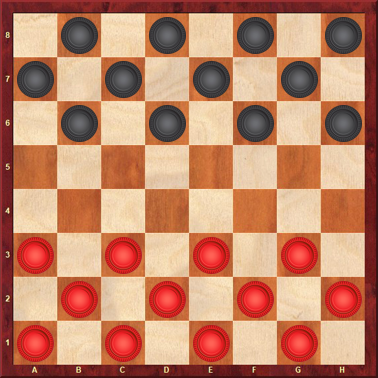

In [127]:
my_board.show()

In [557]:
new_board = draughts.Board()

def play(move):
    new_board.push(move)
    output_vec = black_model.predict(np.array([preprocessing.board_layout_to_network_input(new_board.engine.layout)]))
#     print(output_vec)
    net_move = preprocessing.network_output_to_move(output_vec[0])
    closest_move = find_closest_move(net_move, new_board.valid_moves())
    print("Network move", net_move)
    print(closest_move)
    new_board.push_move(closest_move)
    display(new_board.show())

Network move Move( e3a1 )
Move( e3g1 )


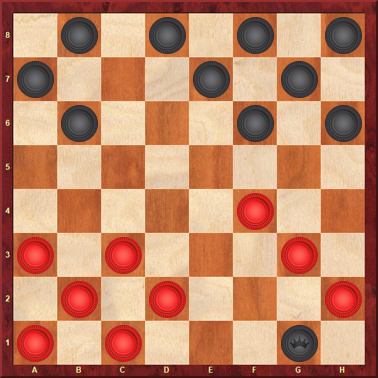

In [563]:
# new_board.push("d6e5")
play("d2e3")

In [519]:
new_board.valid_moves()

(Move( d4b6 ),)